# Bulk Walkthrough

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
from PAGEpy import plot_functions
from PAGEpy import pso as pso
from PAGEpy.dataset_class import GeneExpressionDataset
from PAGEpy.models import AdvancedNN, SimpleNN, TrainingConfig
import pickle
import pandas as pd
from PAGEpy import PAGEpy_utils

# memory growth is enabled for for the gpu
gpu_available = PAGEpy_utils.init_cuda()

19:35:54 [PAGEpy_utils:15] Memory growth enabled for 1 GPU(s)
19:35:54 [PAGEpy_utils:20] GPU devices available: 1


## Create Dataset

In [3]:
# TODO: instead of file patterns, use whole filenames
current_data = GeneExpressionDataset(
    data_dir="../../bulk_data/",
    counts_pattern="count_matrix.mtx",
    barcodes_pattern="sample_names.txt",
    # I think here it's possible to set already processed gene list:
    genes_pattern="gene_names.txt",
    metadata_pattern="response_labels.csv",
    gene_selection="Diff",
    pval_cutoff=0.00005,
    pval_correction="benjamini-hochberg",
    features_out_filename="bulk_feature_set.pkl",
    train_samples_out_filename="bulk_train_samples.txt",
    positive_label="yes"  # TODO: find out how Sean encoded it
)

19:35:54 [dataset_class:133] AnnData object constructed with 831 samples and 11528 features (genes).
19:35:54 [dataset_class:140] Counts normalized and log-transformed.
19:35:54 [dataset_class:192] Split data: 664 training samples, 167 test samples.
... storing 'Status' as categorical
... storing 'split' as categorical
19:35:55 [dataset_class:246] Selected 1757 features using Diff


In [4]:
# the selected genes can be loaded from the local directory, however, they are
# also an attribte of the GeneExpressionDataset object
genes_path = "bulk_feature_set.pkl"

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)
print(f"Loaded {len(current_genes)} genes as 'current_genes'")

Loaded 1757 genes as 'current_genes'


## Initialize and train NN Model

Set NN model parameters

In [5]:
# retrieved default params used in Sean's code
config = TrainingConfig(
    report_frequency=1,
    auc_threshold=1,
    learning_rate=0.001)

training_params = {
    # 'n_epochs': 50,
    'n_epochs': 500,
    'batch_size': 64,
    'seed': 42,
}

Train NN model before PSO

In [6]:
# Initialize NN model
initial_model = AdvancedNN(
    # initial_model = SimpleNN(
    n_input_features=len(current_genes),
    config=config,
)

# Train model
train_history = initial_model.train(
    x_train=current_data.x_train,
    y_train=current_data.y_train,
    x_test=current_data.x_test,
    y_test=current_data.y_test,
    **training_params,
)

19:35:58 [models:505] Epoch 10/500:
	Train Loss: 0.6702, AUC: 0.6841, Acc: 0.3991
	Test AUC: 0.5973, Acc: 0.3892
19:35:59 [models:391] Epoch 12: Adjusting learning rate to 0.005000
19:36:01 [models:505] Epoch 20/500:
	Train Loss: 0.5485, AUC: 0.6974, Acc: 0.5000
	Test AUC: 0.6024, Acc: 0.4850
19:36:03 [models:505] Epoch 30/500:
	Train Loss: 0.4233, AUC: 0.8832, Acc: 0.7711
	Test AUC: 0.6148, Acc: 0.6108
19:36:05 [models:505] Epoch 40/500:
	Train Loss: 0.3213, AUC: 0.8667, Acc: 0.8419
	Test AUC: 0.5642, Acc: 0.6766
19:36:07 [models:505] Epoch 50/500:
	Train Loss: 0.3423, AUC: 0.5005, Acc: 0.6340
	Test AUC: 0.4371, Acc: 0.5808
19:36:09 [models:505] Epoch 60/500:
	Train Loss: 0.6575, AUC: 0.7123, Acc: 0.6702
	Test AUC: 0.4826, Acc: 0.5210
19:36:11 [models:505] Epoch 70/500:
	Train Loss: 0.2431, AUC: 0.8051, Acc: 0.7289
	Test AUC: 0.5572, Acc: 0.7246
19:36:13 [models:505] Epoch 80/500:
	Train Loss: 0.3097, AUC: 0.9180, Acc: 0.7349
	Test AUC: 0.5268, Acc: 0.7246
19:36:16 [models:505] Epoch 

19:37:43 [plot_functions:29] Max metrics
	Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.74 | Test AUC: 0.64


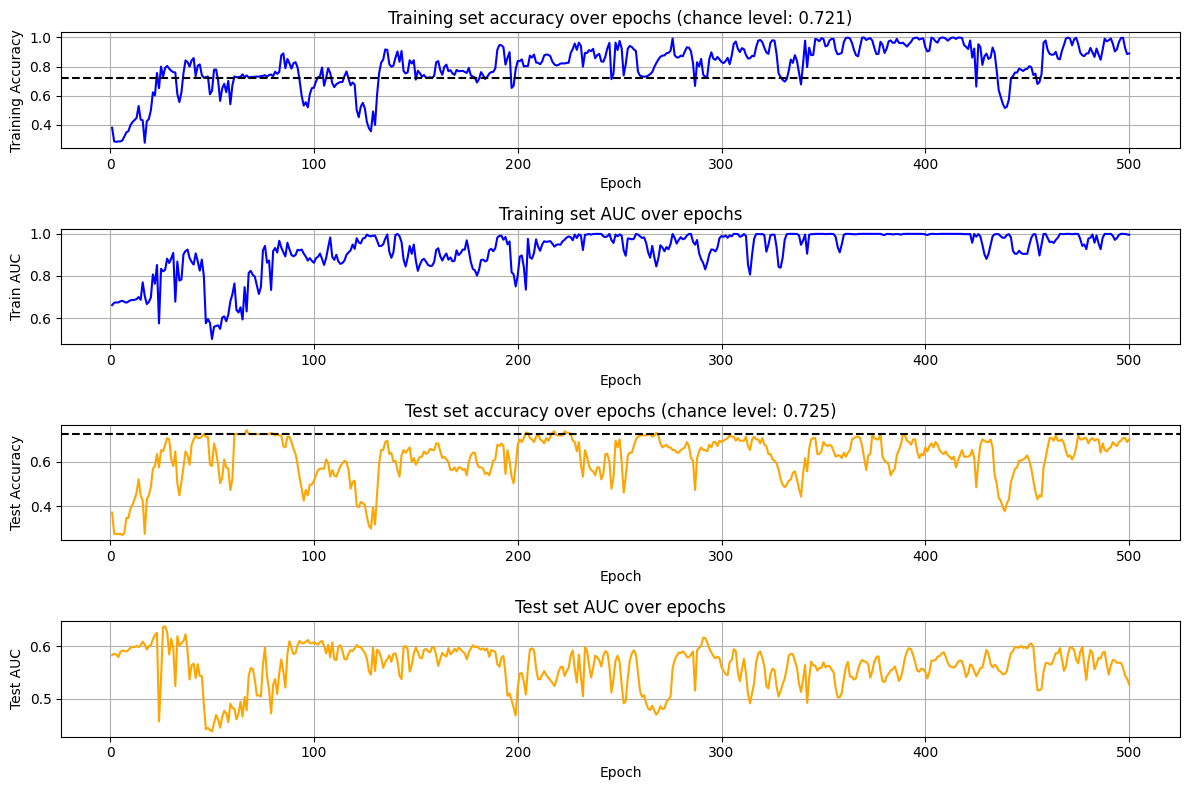

In [7]:
plot_functions.plot_model_history(
    model_history=train_history,
    report_frequency=initial_model.config.report_frequency,
    y_train=current_data.y_train,
    y_test=current_data.y_test,
    save_path=None
)

## Run binary PSO

TO DO: is the algorithm leveraging the GPU??

In [9]:
# the pso algorithm can be use to optimze the solution
best_solution, best_fitness = pso.run_binary_pso(
    input_data=current_data,
    feature_names=current_genes,
    # pop_size=200,
    pop_size=5,
    # n_generations=15,
    n_generations=2,
    w=1,
    c1=2,
    c2=1.5,
    # n_reps=4,
    n_reps=1,
    verbose=True,
    # verbose=False,
    adaptive_metrics=False
)

19:37:43 [pso:203] ============================================================
19:37:43 [pso:204] Generation 1 started
19:37:55 [fitness_functions:134] Particle 1: Genes=850 | Mean AUC=0.348 | Time=11.61s
19:38:06 [fitness_functions:134] Particle 2: Genes=852 | Mean AUC=0.445 | Time=11.02s
19:38:17 [fitness_functions:134] Particle 3: Genes=882 | Mean AUC=0.362 | Time=11.33s
19:38:29 [fitness_functions:134] Particle 4: Genes=870 | Mean AUC=0.423 | Time=11.44s
19:38:40 [fitness_functions:134] Particle 5: Genes=908 | Mean AUC=0.379 | Time=11.42s
19:38:40 [pso:246] Generation 1 summary: Best AUC: 0.4451 | Average AUC: 0.3916 | Duration: 56.91s
19:38:40 [pso:203] ============================================================
19:38:40 [pso:204] Generation 2 started
19:38:52 [fitness_functions:134] Particle 1: Genes=856 | Mean AUC=0.341 | Time=11.84s
19:39:04 [fitness_functions:134] Particle 2: Genes=868 | Mean AUC=0.360 | Time=11.64s
19:39:16 [fitness_functions:134] Particle 3: Genes=860 | Me

In [10]:
# the results of pso optimizatoin can be monitored
loaded_fitness_scores = pd.read_pickle("pso_fitness_scores.pkl")
loaded_particle_history = pd.read_pickle("pso_particle_history.pkl")

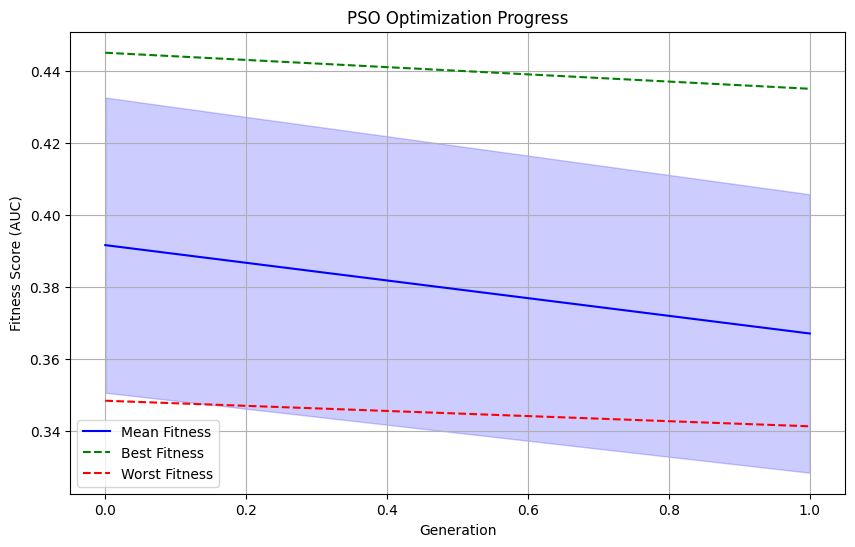

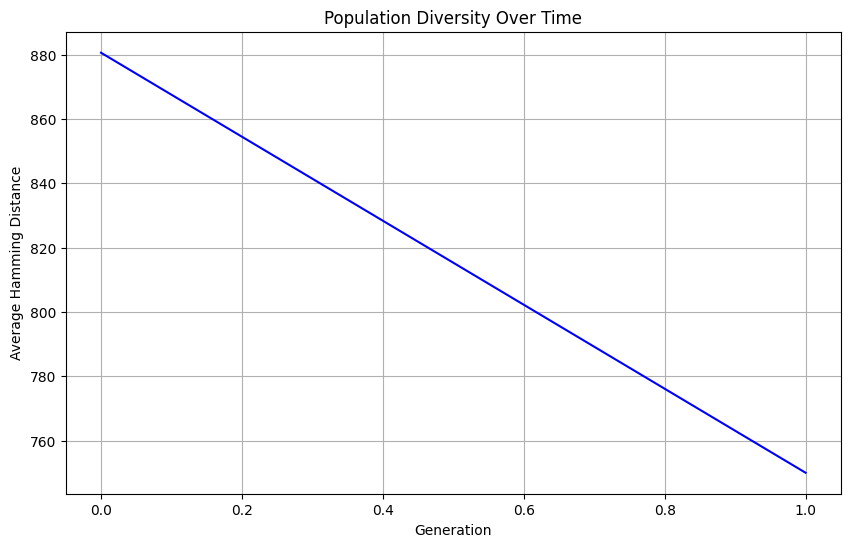

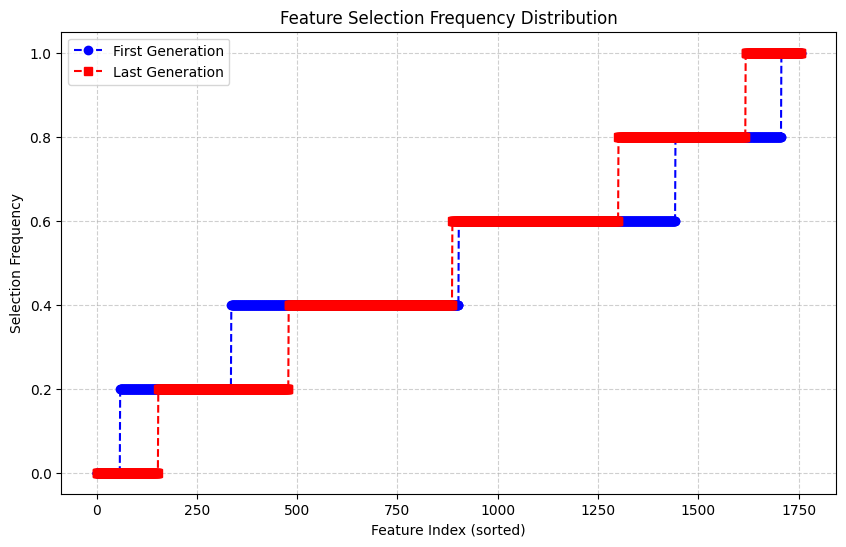

In [11]:
plot_functions.plot_pso_fitness_evolution(loaded_fitness_scores)
plot_functions.plot_population_diversity(loaded_particle_history)
plot_functions.plot_feature_selection_frequency(
    loaded_particle_history)

## Initialize and train improved NN Model

In [12]:
# the optimised solution is saved locally, however, the returned varible from
# the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open("pso_selected_genes.pkl", "rb") as f:
    pso_genes = pickle.load(f)

In [13]:
# now use this gene list to train a new model, which you can then evaluate
n_pso_input_features = len(pso_genes)

improved_model = AdvancedNN(
    # improved_model = SimpleNN(
    n_input_features=n_pso_input_features,
    config=config,
)

# select feature subset and scale data
x_train, x_test, y_train, y_test = current_data.get_scaled_feature_subset(
    feature_subset=pso_genes
)

# Train model
improved_train_history = improved_model.train(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    **training_params,
)

19:39:44 [models:505] Epoch 10/500:
	Train Loss: 0.6227, AUC: 0.7130, Acc: 0.3163
	Test AUC: 0.5874, Acc: 0.2934
19:39:45 [models:391] Epoch 13: Adjusting learning rate to 0.005000
19:39:46 [models:505] Epoch 20/500:
	Train Loss: 0.5189, AUC: 0.7209, Acc: 0.2952
	Test AUC: 0.5962, Acc: 0.2695
19:39:48 [models:505] Epoch 30/500:
	Train Loss: 0.3859, AUC: 0.7947, Acc: 0.3434
	Test AUC: 0.6061, Acc: 0.3234
19:39:50 [models:505] Epoch 40/500:
	Train Loss: 0.2858, AUC: 0.8031, Acc: 0.3057
	Test AUC: 0.5865, Acc: 0.2754
19:39:52 [models:505] Epoch 50/500:
	Train Loss: 0.3210, AUC: 0.9607, Acc: 0.7997
	Test AUC: 0.5336, Acc: 0.5090
19:39:54 [models:505] Epoch 60/500:
	Train Loss: 0.2582, AUC: 0.8805, Acc: 0.6852
	Test AUC: 0.5627, Acc: 0.5030
19:39:56 [models:505] Epoch 70/500:
	Train Loss: 0.2031, AUC: 0.8750, Acc: 0.7771
	Test AUC: 0.6172, Acc: 0.6407
19:39:58 [models:505] Epoch 80/500:
	Train Loss: 0.3295, AUC: 0.8592, Acc: 0.8163
	Test AUC: 0.5206, Acc: 0.6946
19:40:00 [models:505] Epoch 

19:41:23 [plot_functions:29] Max metrics
	Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.74 | Test AUC: 0.63


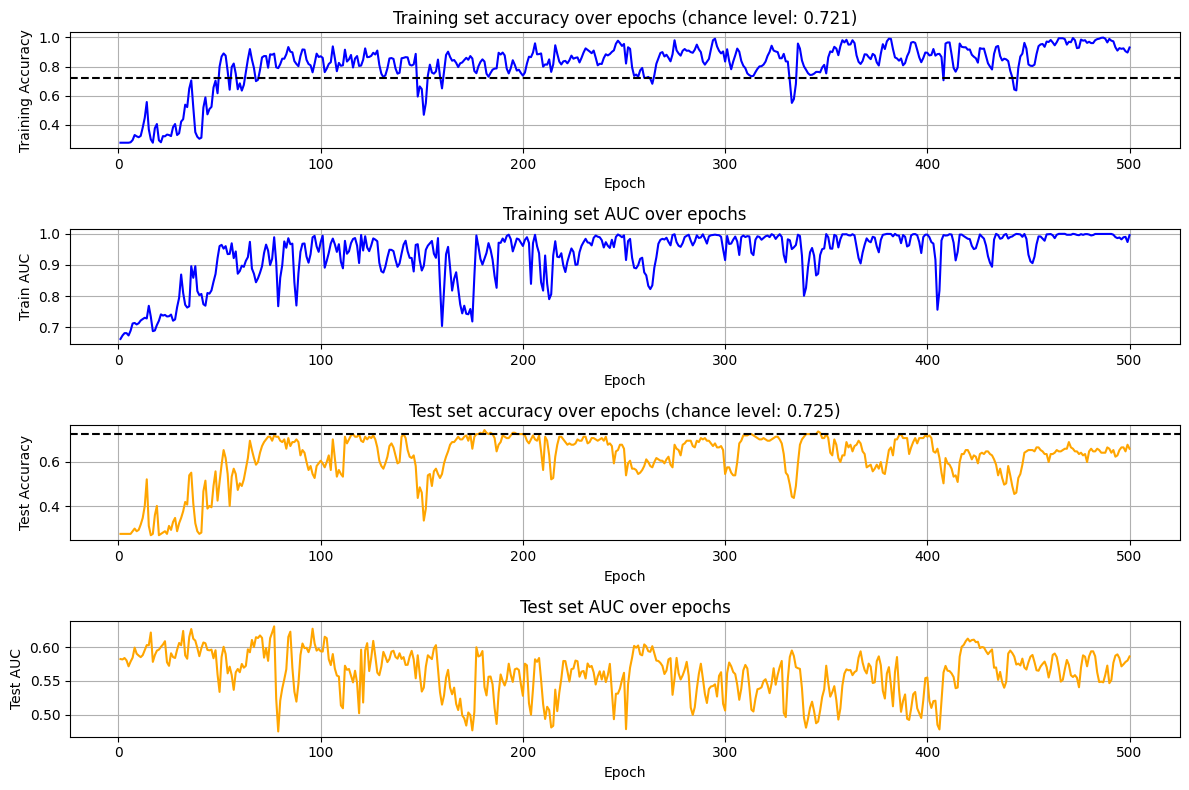

In [14]:
plot_functions.plot_model_history(
    model_history=improved_train_history,
    report_frequency=improved_model.config.report_frequency,
    y_train=y_train,
    y_test=y_test,
    save_path=None
)